## 2.6 概率
简单地说，机器学习就是做出预测。

根据病人的临床历史，我们可能想预测他们在下一年心脏病发作的概率。在飞机喷气发动机的异常检测中，我们想要评估一组发动机读数为正常运心情况的概率有多大。在强化学习中，我们希望智能体(agent)能在一个环境中智能地行动。这意味着我们需要考虑在每种可行的行为下获得高奖励的概率。

现在我们考虑第一个例子：根据照片区分猫和狗。这听起来很简单，但对于机器却可能是一个艰巨的挑战。首先，问题的难度可能取决于图像的分辨率。

<div align=center>
<img src='../../pics/2_6_1.jpeg' width='50%' div align='center'>
</div>

如上图所示，虽然人类很容易以$160 \times 160$像素的分辨率识别猫和狗，但它在$40 \times 40$像素上变得具有挑战性，而且在$10 \times 10$像素下几乎是不可能的。换句话说，我们在很远的距离区分猫和狗的能力可能会变为猜测。概率给了我们一种正式的途径来说明我们的确定性水平。如果我们完全肯定图像是一只猫，我们说标签$y$是"猫"的概率，表示为$P(y="猫")$等于1。如果我们没有证据表明$y=$"猫"或者$y=$"狗"，那么我们可以说这两种可能性是相等的，即$P(y="cat")=P(y="dog")=0.5$。如果我们不是分确定图像描绘的，我们可以将概率赋值为$0.5<P(y="cat")<1$

在这两种情况下，我们都不确定结果，但这两种情况之间有一个关键区别。在第一种情况中，图像实际上是狗或猫二选一。在第二种情况下，结果实际上是一个随机的事件。因此，概率是一种灵活的语言，用于说明我们的确定程度，并且它可以有效地应用于广泛的领域中。

### 2.6.1 基本概率论
假设我们掷骰子，想知道看到1的几率有多大，而不是看到另一个数字。如果骰子是公平的，那么所有六个结果{1, ..., 6}都有相同的可能发生，因此我们可以说1发生的概率为$\frac {1}{6}$

然而现实生活中，对于我们从工厂收到的真实骰子，我们需要检查它是否有瑕疵。检查骰子的唯一方法是多次投掷并记录结果。对于每个骰子，我们将观察到{1, ..., 6}中的一个值。对于每个值，一种自然的方法是将它出现的次数除以投掷的总次数，即此事件(event)概率的估计值。大数定律(law of large numbers)告诉我们：随着透支次数的增加，这个估计值会越来越接近真实的潜在概率。

首先，我们导入必要的软件包

In [1]:
%matplotlib inline
import torch
from torch.distributions import multinomial
from d2l import torch as d2l

在统计学中，我们把从概率分布中抽取样本的过程称为抽样(sampling)。笼统来说，可以把分布(distribution)看作是对事件的概率分配。将概率分配给一些离散选择的分布称为多项式分布(multinomial distribution)。

为了抽取一个样本，即掷骰子，我们只需要传入一个概率向量。输出是另一个相同长度的向量：它在索引$i$处的值是采样结果中$i$出现的次数。

In [2]:
fair_probs = torch.ones([6]) / 6
multinomial.Multinomial(1, fair_probs).sample()

tensor([0., 0., 0., 0., 1., 0.])

现在我们知道如何对骰子进行采样，我们可以模拟1000次投掷。然后，我们可以统计1000次投掷后，每个数字被投中了多少次。具体来说，我们计算相对频率，以作为真实概率的估计。

In [3]:
#将结果存储为32位浮点数以进行除法
counts = multinomial.Multinomial(1000, fair_probs).sample()
counts / 1000 #相对频率作为估计值

tensor([0.1650, 0.1890, 0.1610, 0.1650, 0.1600, 0.1600])

因为我们是从一个公平的骰子中生成的数据，我们知道每个结果都有真实的概率$\frac{1}{6}$，大约是0.167，所以上面输出的估计值还不错。

我们也可以看到这些概率如何随着时间的推移收敛到真实概率。让我们进行500组实验，每组抽取10个样本

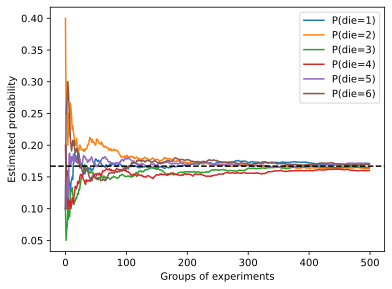

In [5]:
counts = multinomial.Multinomial(10, fair_probs).sample((500,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdim=True)

d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(),
            label=("P(die=" + str(i + 1) + ")"))
        
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend()
d2l.plt.show()

每条实现对应于骰子的6个值中的一个，并给出骰子在每组实验后出现值的估计概率。当我们通过更多的实验获得更多的数据时，这6条实体曲线向真实概率收敛。

**概率论公理**

在处理骰子掷出时，我们将集合$S=${1, 2, 3, 4, 5, 6}称为样本空间(sample space)或结果空间(outcome space)，其中每个元素都是结果(outcome)。事件(event)是一组给定样本空间的随机结果。

概率(probabilty)可以被认为是将集合映射到真实值的函数。在给定的样本空间$S$中，事件$A$的概率，表示为$P(A)$，满足以下属性：
- 对于任意事件$A$，其概率从不会是负数，即$P(A)≥0$
- 整个样本空间的概率为1，即$P(S)=1$
- 对于互斥(multually exclusive)事件(对于所有$i ≠ j$都有$A_i \cap A_j = \emptyset$)的任意一个可数序列$A_1, A_2, ...,$序列中，任意一个事件发生的概率等于它们各自发生的概率之和，即$P(\bigcup_{i=1}^\infty A_i)= \sum_{i=1}^\infty P(A_i)$。

以上也是概率论的公理，由柯尔莫戈罗夫于1933年提出。有了这个公理系统，我们可以避免任何关于随机性的哲学争论；相反我们可以用数学语言严格地推理。假如事件$A_1$为整个样本空间，且当所有$i>1$时的$A_i = \emptyset$，那么我们可以证明$P(\emptyset)=0$，即不可能发生事件的概率是0.

**随机变量**

在我们掷骰子的随机实验中，我们引入了随机变量(random variable)的概念。随机变量几乎可以是任何数量，并且它可以在随机实验的一组可能性中取一个值。考虑一个随机变量$X$，其值在掷骰子的样本空间$S=${1,2,3,4,5,6}中。我们可以将事件“看到一个5”表示为{$X=5$}或$X=5$，其概率表示为$P$({$X=5$})或$P(X=5)$。通过P{$X=a$}，我们区分了随机变量$X$和$X$可以采取的值(例如a)。然而，这可能会导致繁琐的表示。为了简化符号，一方面我们可以将$P(X)$表示为随机变量$X$上的分布(distribution)：分布告诉我们$X$获得某一值的概率。另一方面，我们可以简单用$P(a)$表示随机变量取值a的概率。由于概率论中的事件是来自样本空间的一组结果，因此我们可以为随机变量指定值的可取范围。例如，$P(1≤X≤3)$表示事件{1≤X≤3}，即{X=1, 2, or, 3}的概率。等价地，$P(1≤X≤3)$表示随机变量X从{1, 2, 3}中取值的概率。

请注意，离散(discrete)随机变量(如骰子的每一面)和连续(continuous)随机变量(如人的体重和身高)之间存在微妙的区别。

### 2.6.2 处理多个随机变量
很多时候，我们会考虑多个随机变量。比如，我们可能需要对疾病和症状之间的关系进行建模。给定一个疾病和一个症状，比如“流感”和“咳嗽”，以某个概率存在或不存在于某个患者身上。我们需要估计这些概率以及概率之间的关系，以便我们可以运用我们的推断来实现更好的医疗服务。

**联合概率**

第一个被称为联合概率(joint probability)$P(A=a, B=b)$。给定任意值a和b，联合概率可以回答：A=a和B=b同时满足的概率是多少？请注意，对于任何a和b的取值，$P(A=a, B=b)≤ P(A=a)$。这点是确定的，因为要同时发生A=a和B=b，A=a就必须发生，B=b也必须发生。因此，A=a和B=b同时发生的可能性不大于A=a或者是B=b单独发生的可能性。

**条件概率**

联合概率的不等式带给我们一个有趣的比率:$0≤\frac{P(A=a, B=b)}{P(A=a)}≤1$。我们称这个比率为条件概率(conditional probability)，并用$P(B=b|A=a)$表示它：它是B=b的概率，前提是A=a已发生。

**贝叶斯定理**

使用条件概率的定义，我们可以得出统计学中最有用的方程之一：Bayes定理(Bayes' theorem)。根据乘法法则(multiplication rule)可得到$P(A,B)=P(B|A)P(A)$。根据对称性，可得到$P(A|B)=P(A|B)P(B)$。假设$P(B)>0$，求解其中一个条件变量，我们得到
$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$
请注意，这里我们使用紧凑的表示法：其中$P(A,B)$是一个联合分布(joint distribution)，$P(A|B)$是一个条件分布(conditional distribution)。这种分布可以在给定值A=a,B=b上进行求值。